In [1]:
# Importing the necessary libraries
import itertools

import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
from PIL import Image
import torch
import random

import glob
import random
import os
import gc
gc.collect()
torch.cuda.empty_cache()
from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as transforms
import torchvision.datasets as dset
import cv2
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.utils as vutils
from IPython.display import clear_output

In [2]:
# Checking torch version
torch.__version__

'1.8.1'

In [3]:
# Initializing root directories
root = "./train"

In [ ]:
scale = 255
class ImageDataset(Dataset):
    def __init__(self, root):
        self.files_A = sorted(glob.glob(root + '/sketches' + '/*.*'))
        self.files_B = sorted(glob.glob(root + '/photos' + '/*.*'))

        self.sketches = np.ones((len(self.files_A), 3, 256, 256))
        self.photos = np.ones((len(self.files_B), 3, 256, 256))

        for i in range(0, len(self.files_A), 1):
            x = cv2.resize(cv2.imread(self.files_A[i]), (256,256))
            bo,go,ro = cv2.split(x)           # get b, g, r
            rgb_imgo = cv2.merge([ro,go,bo]) 
            self.sketches[i] = rgb_imgo.transpose(2, 1, 0)
            y = cv2.resize(cv2.imread(self.files_B[i]), (256,256))
            bp,gp,rp = cv2.split(y)           # get b, g, r
            rgb_imgp = cv2.merge([rp,gp,bp]) 
            self.photos[i] = rgb_imgp.transpose(2, 1, 0)
        
        # Normalization between -1 to 1
        self.sketches = torch.from_numpy(((self.sketches/(scale / 2)) -1 )).float()
        self.photos = torch.from_numpy(((self.photos/(scale / 2)) -1 )).float()


    def __getitem__(self, index):
        return {'Sketches': self.sketches[index], 'Photos': self.photos[index]}

    def __len__(self):
        return len(self.files_A)

In [ ]:
# Creating the data loader
batch_size = 4
dataloader = DataLoader(ImageDataset(root), batch_size = 4, shuffle=True)

In [4]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        # A bunch of convolutions one after another
        model = [   nn.Conv2d(3, 64, 4, stride=2, padding=1),
                    nn.LeakyReLU(0.2, inplace=True) ]

        model += [  nn.Conv2d(64, 128, 4, stride=2, padding=1),
                    nn.InstanceNorm2d(128), 
                    nn.LeakyReLU(0.2, inplace=True) ]

        model += [  nn.Conv2d(128, 256, 4, stride=2, padding=1),
                    nn.InstanceNorm2d(256), 
                    nn.LeakyReLU(0.2, inplace=True) ]

        model += [  nn.Conv2d(256, 512, 4, padding=1),
                    nn.InstanceNorm2d(512), 
                    nn.LeakyReLU(0.2, inplace=True) ]

        # FCN classification layer
        model += [nn.Conv2d(512, 1, 4, padding=1)]

        self.model = nn.Sequential(*model)

    def forward(self, x):
        x =  self.model(x)
        # Average pooling and flatten
        return F.avg_pool2d(x, x.size()[2:]).view(x.size()[0], -1)

In [5]:
class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()

        conv_block = [  nn.ReflectionPad2d(1),
                        nn.Conv2d(in_features, in_features, 3),
                        nn.InstanceNorm2d(in_features),
                        nn.ReLU(inplace=True),
                        nn.ReflectionPad2d(1),
                        nn.Conv2d(in_features, in_features, 3),
                        nn.InstanceNorm2d(in_features)  ]

        self.conv_block = nn.Sequential(*conv_block)

    def forward(self, x):
        return x + self.conv_block(x)

In [6]:
class Generator(nn.Module):
    def __init__(self, n_residual_blocks=6):
        super(Generator, self).__init__()

        # Initial convolution block       
        model = [   nn.ReflectionPad2d(3),
                    nn.Conv2d(3, 64, 7),
                    nn.InstanceNorm2d(64),
                    nn.ReLU(inplace=True) ]

        # Downsampling
        in_features = 64
        out_features = in_features*2
        for _ in range(2):
            model += [  nn.Conv2d(in_features, out_features, 3, stride=2, padding=1),
                        nn.InstanceNorm2d(out_features),
                        nn.ReLU(inplace=True) ]
            in_features = out_features
            out_features = in_features*2

        # Residual blocks
        for _ in range(n_residual_blocks):
            model += [ResidualBlock(in_features)]

        # Upsampling
        out_features = in_features//2
        for _ in range(2):
            model += [  nn.ConvTranspose2d(in_features, out_features, 3, stride=2, padding=1, output_padding=1),
                        nn.InstanceNorm2d(out_features),
                        nn.ReLU(inplace=True) ]
            in_features = out_features
            out_features = in_features//2

        # Output layer
        model += [  nn.ReflectionPad2d(3),
                    nn.Conv2d(64, 3, 7),
                    nn.Tanh() ]

        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)

In [ ]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.normal(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm2d') != -1:
        torch.nn.init.normal(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant(m.bias.data, 0.0)

In [ ]:
# create model
netG_A2B = Generator().float().cuda()
#netG_A2B.load_state_dict(torch.load("./models/netG_A2B_epoch_127.pth"))
netG_B2A = Generator().float().cuda()
#netG_B2A.load_state_dict(torch.load("./models/netG_B2A_epoch_127.pth"))
netD_A = Discriminator().float().cuda()
#netD_A.load_state_dict(torch.load("./models/netD_A_epoch_127.pth"))
netD_B = Discriminator().float().cuda()
#netD_B.load_state_dict(torch.load("./models/netD_B_epoch_127.pth"))

netG_A2B.apply(weights_init_normal)
netG_B2A.apply(weights_init_normal)
netD_A.apply(weights_init_normal)
netD_B.apply(weights_init_normal)
clear_output()

In [7]:
class LambdaLR():
    def __init__(self, n_epochs, offset, decay_start_epoch):
        assert ((n_epochs - decay_start_epoch) > 0), "Decay must start before the training session ends!"
        self.n_epochs = n_epochs
        self.offset = offset
        self.decay_start_epoch = decay_start_epoch

    def step(self, epoch):
        return 1.0 - max(0, epoch + self.offset - self.decay_start_epoch)/(self.n_epochs - self.decay_start_epoch)


In [8]:
class ReplayBuffer():
    def __init__(self, max_size=50):
        assert (max_size > 0), 'Empty buffer or trying to create a black hole. Be careful.'
        self.max_size = max_size
        self.data = []

    def push_and_pop(self, data):
        to_return = []
        for element in data.data:
            element = torch.unsqueeze(element, 0)
            if len(self.data) < self.max_size:
                self.data.append(element)
                to_return.append(element)
            else:
                if random.uniform(0,1) > 0.5:
                    i = random.randint(0, self.max_size-1)
                    to_return.append(self.data[i].clone())
                    self.data[i] = element
                else:
                    to_return.append(element)
        return Variable(torch.cat(to_return))

In [ ]:
# Lossess
criterion_GAN = torch.nn.MSELoss()
criterion_cycle = torch.nn.L1Loss()
criterion_identity = torch.nn.L1Loss()

# Optimizers & LR schedulers
optimizer_G = torch.optim.Adam(itertools.chain(netG_A2B.parameters(), netG_B2A.parameters()),
                                lr=0.0002, betas=(0.5, 0.999))
optimizer_D_A = torch.optim.Adam(netD_A.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D_B = torch.optim.Adam(netD_B.parameters(), lr=0.0002, betas=(0.5, 0.999))

lr_scheduler_G = torch.optim.lr_scheduler.LambdaLR(optimizer_G, lr_lambda=LambdaLR(200, 0, 100).step)
lr_scheduler_D_A = torch.optim.lr_scheduler.LambdaLR(optimizer_D_A, lr_lambda=LambdaLR(200, 0, 100).step)
lr_scheduler_D_B = torch.optim.lr_scheduler.LambdaLR(optimizer_D_B, lr_lambda=LambdaLR(200, 0, 100).step)


In [ ]:
# Inputs & targets memory allocation
cuda = True
Tensor = torch.cuda.FloatTensor if cuda else torch.Tensor

fake_A_buffer = ReplayBuffer()
fake_B_buffer = ReplayBuffer()

In [ ]:
# clearing the previous result
outf = "./results8"
models = "./models"

In [ ]:
epochs = 200
for epoch in range(0, epochs):
    for i, batch in enumerate(dataloader, 0):
        
        target_real = Variable(Tensor(len(batch['Sketches'])).fill_(1.0), requires_grad=False)
        target_fake = Variable(Tensor(len(batch['Photos'])).fill_(0.0), requires_grad=False)
        
        # Set model input
        input_A = Tensor(len(batch['Sketches']), 3, 256, 256)
        input_B = Tensor(len(batch['Photos']), 3, 256, 256)
#         print(input_A.shape)
        real_A = Variable(input_A.copy_(batch['Sketches']).cuda())
        real_B = Variable(input_B.copy_(batch['Photos']).cuda())

        ###### Generators A2B and B2A ######
        optimizer_G.zero_grad()

        # Identity loss
        # G_A2B(B) should equal B if real B is fed
        same_B = netG_A2B(real_B)
        loss_identity_B = criterion_identity(same_B, real_B)*5.0
        # G_B2A(A) should equal A if real A is fed
        same_A = netG_B2A(real_A)
        loss_identity_A = criterion_identity(same_A, real_A)*5.0

        # GAN loss
        fake_B = netG_A2B(real_A)
        pred_fake = netD_B(fake_B)
        loss_GAN_A2B = criterion_GAN(pred_fake, target_real)

        fake_A = netG_B2A(real_B)
        pred_fake = netD_A(fake_A)
        loss_GAN_B2A = criterion_GAN(pred_fake, target_real)

        # Cycle loss
        recovered_A = netG_B2A(fake_B)
        loss_cycle_ABA = criterion_cycle(recovered_A, real_A)*10.0

        recovered_B = netG_A2B(fake_A)
        loss_cycle_BAB = criterion_cycle(recovered_B, real_B)*10.0

        # Total loss
        loss_G = loss_identity_A + loss_identity_B + loss_GAN_A2B + loss_GAN_B2A + loss_cycle_ABA + loss_cycle_BAB
        loss_G.backward()
        
        optimizer_G.step()
        ###################################

        ###### Discriminator A ######
        optimizer_D_A.zero_grad()

        # Real loss
        pred_real = netD_A(real_A)
        loss_D_real = criterion_GAN(pred_real, target_real)

        # Fake loss
        fake_A = fake_A_buffer.push_and_pop(fake_A)
        pred_fake = netD_A(fake_A.detach())
        loss_D_fake = criterion_GAN(pred_fake, target_fake)

        # Total loss
        loss_D_A = (loss_D_real + loss_D_fake)*0.5
        loss_D_A.backward()

        optimizer_D_A.step()
        ###################################

        ###### Discriminator B ######
        optimizer_D_B.zero_grad()

        # Real loss
        pred_real = netD_B(real_B)
        loss_D_real = criterion_GAN(pred_real, target_real)
        
        # Fake loss
        fake_B = fake_B_buffer.push_and_pop(fake_B)
        pred_fake = netD_B(fake_B.detach())
        loss_D_fake = criterion_GAN(pred_fake, target_fake)

        # Total loss
        loss_D_B = (loss_D_real + loss_D_fake)*0.5
        loss_D_B.backward()

        optimizer_D_B.step()
        ###################################

        # Progress report (http://localhost:8097)
        # logger.log({'loss_G': loss_G, 'loss_G_identity': (loss_identity_A + loss_identity_B), 'loss_G_GAN': (loss_GAN_A2B + loss_GAN_B2A),
        #             'loss_G_cycle': (loss_cycle_ABA + loss_cycle_BAB), 'loss_D': (loss_D_A + loss_D_B)}, 
        #             images={'real_A': real_A, 'real_B': real_B, 'fake_A': fake_A, 'fake_B': fake_B})

#         progress_bar.set_description(
#             f"[{epoch}/{epochs - 1}][{i}/{len(dataloader) - 1}] "
#             f"Loss_D: {(loss_D_A  + loss_D_B).item():.4f} "
#             f"Loss_G: {loss_G.item():.4f} "
#             f"Loss_G_identity: {(loss_identity_A + loss_identity_B).item():.4f} "
#             f"loss_G_GAN: {(loss_GAN_A2B + loss_GAN_B2A).item():.4f} "
#             f"loss_G_cycle: {(loss_cycle_ABA + loss_cycle_BAB).item():.4f}")
        
        print("[%d/%d] [%d/%d] Loss_D: %.5f Loss_G: %.5f" % (epoch, epochs, i, len(dataloader), (loss_D_A  + loss_D_B).item(), loss_G.item()/10))
        
        if i % 1135 == 0 and i != 0:
            vutils.save_image(real_A,
                              f"{outf}/Sketch_real_samples_epoch_{epoch}_{i}.png",
                              normalize=True)
            vutils.save_image(real_B,
                              f"{outf}/Photo_real_samples_epoch_{epoch}_{i}.png",
                              normalize=True)

            fake_image_A = 0.5 * (netG_B2A(real_B).data + 1.0)
            fake_image_B = 0.5 * (netG_A2B(real_A).data + 1.0)

            vutils.save_image(fake_image_A.detach(),
                              f"{outf}/Sketch_fake_samples_epoch_{epoch}_{i}.png",
                              normalize=True)
            vutils.save_image(fake_image_B.detach(),
                              f"{outf}/Photo_fake_samples_epoch_{epoch}_{i}.png",
                              normalize=True)
            # Saving the loss in file
            f = open(outf + "LOG.txt", "a+")
            f.write("[%d/%d] [%d/%d] Loss_D: %.5f Loss_G: %.5f" % (epoch, epochs, i, len(dataloader), (loss_D_A  + loss_D_B).item(), loss_G.item()/10))
            f.close()
            clear_output()

    # do check pointing
    if epoch % 50 == 0 and epoch != 0:
        torch.save(netG_A2B.state_dict(), f"{models}/netG_A2B_epoch_{epoch}.pth")
        torch.save(netG_B2A.state_dict(), f"{models}/netG_B2A_epoch_{epoch}.pth")
        torch.save(netD_A.state_dict(), f"{models}/netD_A_epoch_{epoch}.pth")
        torch.save(netD_B.state_dict(), f"{models}/netD_B_epoch_{epoch}.pth")


    # Update learning rates
    lr_scheduler_G.step()
    lr_scheduler_D_A.step()
    lr_scheduler_D_B.step()

# Save models checkpoints
torch.save(netG_A2B.state_dict(), f"{models}/netG_A2B_final.pth")
torch.save(netG_B2A.state_dict(), f"{models}/netG_B2A_final.pth")
torch.save(netD_A.state_dict(), f"{models}/netD_A_final.pth")
torch.save(netD_B.state_dict(), f"{models}/netD_B_final.pth")
###################################

In [9]:
netG_A2B_test = Generator().float().cuda()
netG_A2B_test.load_state_dict(torch.load("./models/netG_A2B_epoch_197.pth"))
netG_A2B_test.eval()

Generator(
  (model): Sequential(
    (0): ReflectionPad2d((3, 3, 3, 3))
    (1): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1))
    (2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (3): ReLU(inplace=True)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (8): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (9): ReLU(inplace=True)
    (10): ResidualBlock(
      (conv_block): Sequential(
        (0): ReflectionPad2d((1, 1, 1, 1))
        (1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
        (2): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (3): ReLU(inplace=True)
        (4): ReflectionPad2d((1, 1, 1, 1))
        (

In [10]:
netG_B2A_test = Generator().float().cuda()
netG_B2A_test.load_state_dict(torch.load("./models/netG_B2A_epoch_197.pth"))
netG_B2A_test.eval()

Generator(
  (model): Sequential(
    (0): ReflectionPad2d((3, 3, 3, 3))
    (1): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1))
    (2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (3): ReLU(inplace=True)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (8): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (9): ReLU(inplace=True)
    (10): ResidualBlock(
      (conv_block): Sequential(
        (0): ReflectionPad2d((1, 1, 1, 1))
        (1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
        (2): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (3): ReLU(inplace=True)
        (4): ReflectionPad2d((1, 1, 1, 1))
        (

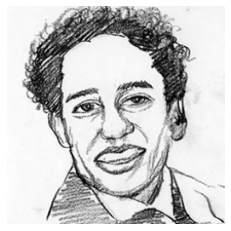

In [11]:
path = "./test/sketches/0013.jpg"
img = cv2.resize(cv2.imread(path), (256,256))
b,g,r = cv2.split(img)           # get b, g, r
rgb_img = cv2.merge([r,g,b])
import matplotlib.pyplot as plt
plt.imshow(rgb_img)
plt.axis('off')
plt.show()

In [12]:
rgb_img = rgb_img.transpose(2,1,0)
img_test = torch.from_numpy(((rgb_img/(255 / 2)) -1 )).float()
img_test = img_test.expand(1,3,256,256)

In [13]:
# fake1 = netG_B2A_test(img_test.to('cuda'))
fake2 = netG_A2B_test(img_test.to('cuda'))
# fake2 = netG_B2A_test(fake1.to('cuda'))

In [14]:
fake_viz = fake2[0].cpu().detach().numpy()
fake_viz = fake_viz.transpose(2,1,0)
fake_viz.shape

(256, 256, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


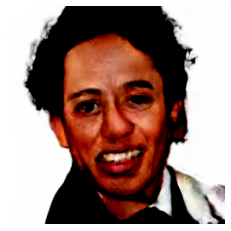

In [15]:
plt.imshow(fake_viz)
plt.axis('off')
plt.show()

In [ ]:
fake_viz = np.transpose(fake_viz, [2,0,1])
fake_viz = torch.from_numpy(fake_viz)
vutils.save_image(fake_viz , 'rb.png' , normalize=True)